Work out how the PS1 mags convert to TESS mags/counts

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 
from delta_kernal import *

In [230]:
# fraction of PS1 filters that cover TESS from the PS_To_TESS_filter notebook
r = 0.677
i = 0.975
z = 0.977
y = 0.673
factor = [r,i,z,y]
factor = [0.41656058, 1.12264514, 0.95252585, 0.76186266]
def Combined_ps1(Table,Coeff):
    filts = [PS1.rmag.values,PS1.imag.values,PS1.zmag.values,PS1.ymag.values]
    flux = np.zeros_like(PS1.rmag.values)
    for i in range(len(Coeff)):
        flux = 10**(-1/2.5*(filts[i]+48.6)) 
        flux += flux * Coeff[i]
    m = -2.5*np.log10(flux) - 48.6
    T = 10**(-1/2.5*(m-20.44))
    ps_wcs = sd.WCS(f)
    return T

def PS1_to_TESS_mag(PS1):
	"""
	https://arxiv.org/pdf/1706.00495.pdf pg.9
	"""
	#coeffs = np.array([0.6767,0.9751,0.9773,0.6725])
	g = PS1.gmag.values
	r = PS1.rmag.values
	i = PS1.imag.values
	z = PS1.zmag.values
	y = PS1.ymag.values

	#t = coeffs[0] * r + coeffs[1] * i #+ coeffs[2] * z + coeffs[3] * y
	t = i - 0.00206*(g - i)**3 - 0.02370*(g - i)**2 + 0.00573*(g - i) - 0.3078
	PS1['tmag'] = t
	return PS1

<IPython.core.display.Javascript object>


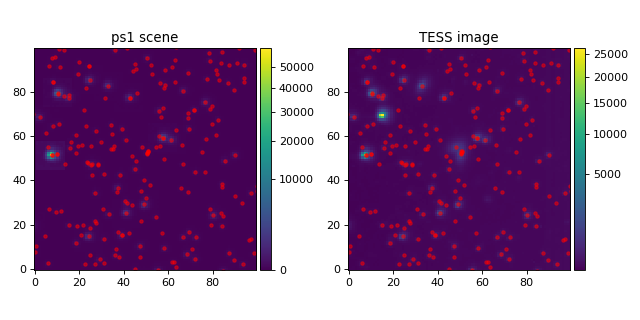

In [231]:
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599
scene, tpf = sd.Catalog_scene(ra,dec,100,Maglim=17, Sector=23, Catalog='ps1',Interpolate=False,Plot=True)#,Save='PS1_catalog_scene.pdf')

In [39]:
cus = np.ones_like(tpf.flux[0])
#cus[20:29,20:29] = 0
cus[45:55,45:55] = 0
bkg = sd.Scene_bkg_estimate(scene,tpf,Limit=.3,Custom_mask=cus)

flux = tpf.flux - bkg
f = flux.copy()
f[f<0] = 0
b = bkg.copy()
b[b==0] = np.nan
me = np.nanmedian(b,axis=0)
ind = np.where(np.nansum(b < me,axis=(1,2)) > (b.shape[1]*2))[0]
low_bkg_flux = flux[ind]
low_bkg_flux[low_bkg_flux==0] = np.nan
median = np.nanmedian(low_bkg_flux,axis=0)
pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=17)
loc,iso,ts = sd.Isolated_stars(pos,Tmag,f,median,scene,Mag=16,Distance=7)

additional mask


/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)



[[ 7  3]
 [59 10]
 [48 11]
 [55 24]
 [85 39]
 [69 35]
 [77 59]
 [16 20]
 [28 35]
 [57 72]
 [34 83]
 [ 3 69]
 [95 92]
 [78 86]
 [67 81]
 [70 89]
 [79 94]
 [51 96]
 [12 92]]


../scenes/utils.py:73: RuntimeWarning: invalid value encountered in less
  median[median<0] = 0


In [5]:
result =  sd.Get_Catalogue(tpf, Catalog = 'ps1')
result = result[np.isfinite(result.rmag) & np.isfinite(result.imag) & np.isfinite(result.zmag)& np.isfinite(result.ymag)]

In [6]:
result

,RAJ2000,DEJ2000,objID,f_objID,Qual,e_RAJ2000,e_DEJ2000,_tab1_10,Ns,Nd,...,zmag,e_zmag,zKmag,e_zKmag,zFlags,ymag,e_ymag,yKmag,e_yKmag,yFlags
0,189.136115,10.651146,120781891362241762,436527104,52,0.0343,0.0375,55989.506493,5,43,...,20.8967,0.1007,20.6683,0.1123,16892216,20.6304,0.1623,20.1418,0.2213,16892216
4,189.259371,10.664220,120791892593897535,436527104,52,0.0146,0.0142,55919.486227,5,56,...,19.9788,0.0395,20.0702,0.0783,115000,19.7036,0.0332,19.7377,0.2114,115000
5,189.260813,10.663707,120791892607676800,436527104,52,0.0290,0.0283,55818.107674,5,34,...,20.9198,0.0447,20.6967,0.0603,115000,19.8349,0.1832,19.9447,0.2893,115000
9,189.286422,10.668306,120801892864862514,436527104,52,0.0070,0.0056,55957.209664,10,66,...,19.0737,0.0066,19.2385,0.0285,115000,18.9782,0.0227,19.0246,0.0403,115000
16,189.281923,10.682890,120821892819820059,444915712,53,0.0151,0.0114,55965.895336,10,73,...,20.2799,0.0548,19.3212,0.0620,16892216,19.8121,0.0503,19.2035,0.0771,16892216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21310,189.064040,11.797903,122151890640557994,503635968,60,0.0042,0.0034,55938.327894,5,74,...,17.9398,0.0056,18.0210,0.0086,115000,17.6579,0.0086,17.7969,0.0166,115000
21311,189.079281,11.811793,122171890793214720,436527104,52,0.0149,0.0135,55978.230660,5,69,...,19.9638,0.0257,19.9381,0.0631,115000,19.8664,0.0476,19.6544,0.0728,115000
21312,189.091447,11.802785,122161890914613884,436527104,52,0.0433,0.0261,55893.430498,5,36,...,20.8219,0.1021,20.5285,0.1316,115000,20.9331,0.2005,20.5367,0.3103,115000
21315,189.125384,11.812847,122171891254196087,436527104,52,0.0285,0.0276,55875.308657,4,26,...,20.7383,0.0519,20.1967,0.0953,16892216,19.8775,0.1418,NaN,NaN,115000


In [207]:
radecs = np.vstack([result['RAJ2000'], result['DEJ2000']]).T
#radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
#Tessmag = result['tmag'].values
#Jmag = result['Jmag']
ind = (((coords[:,0] >= 0) & (coords[:,1] >= 0)) & 
       ((coords[:,0] < (tpf.shape[1] + 1)) & (coords[:,1] < (tpf.shape[2] + 1))))
coords = coords[ind]
r = result.iloc[ind]

In [16]:
coords.shape

(2616, 2)

In [67]:
loc[0,:]

array([7, 3])

(array([186]),)

In [208]:
factor = np.array([r,i,z,y])
factor = np.array([0.94691754, 0.98808461, 1.03382218, 1.1097075 ])
filts = np.array([result.rmag.values,result.imag.values,result.zmag.values,result.ymag.values])
flux = np.zeros_like(result.rmag.values)
for i in range(len(factor)):
    f = 10**(-1/2.5*(filts[i]+48.6)) 
    flux += f * factor[i]
m = -2.5*np.log10(flux) - 48.6
T = 10**(-1/2.5*(m-20.44))

In [210]:
coords

array([[ 96.09422079,   1.64561829],
       [ 94.03030565,   0.72946858],
       [ 95.10728441,   2.64598966],
       ...,
       [  0.92027771,  97.75869699],
       [  1.20826606,  99.99088577],
       [  1.28888003, 100.63100533]])

In [218]:
ind = np.where(((coords[:,0]).astype(int) == loc[0,0]) & ((coords[:,1]).astype(int) == loc[0,1]))[0][0]

In [220]:
isolated = result.iloc[ind]

In [221]:
isolated['RAJ2000'], isolated['DEJ2000']

(189.12814017, 10.79149176)

In [228]:
c1 = np.nansum(iso[2,0])
c2 = np.nansum(iso[2,1])

In [229]:
c1,c2

(90.5740129077988, 102.44564437866211)

In [36]:
5//2

2

In [38]:
f.shape

(8373,)

In [201]:
def Isolated_stars(pos,Tmag,flux,Median,sources, Distance = 7, Mag = 16):
    """
    Find isolated stars in the scene.
    """
    #pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=18)
    pos_shift = pos -.5
    ind = ((Distance//2< pos_shift[:,0]) & (pos_shift[:,0]< flux.shape[1]-Distance//2) & 
          (Distance//2< pos_shift[:,1]) & (pos_shift[:,1]< flux.shape[1]-Distance//2) &
          (Tmag < Mag))
    if ~ind.any():
        raise ValueError('No sources brighter than {} Tmag.'.format(Mag))
    p = pos_shift[ind,:]
    distance= np.zeros([len(p),len(p)])
    for i in range(len(p)):
        distance[i] = np.sqrt((p[i,0] - p[:,0])**2 + (p[i,1] - p[:,1])**2)
    distance[distance==0] = np.nan
    mins = np.nanmin(distance,axis=1)
    iso = p[mins > Distance]
    iso = iso.astype('int')
    iso_s = sources[ind]
    iso_s = iso_s[mins > Distance]
    median = Median
    median[median<0] = 0
    if len(iso)> 0:
        clips = []
        time_series = []
        if (Distance % 2) ==0:
            d = Distance - 1
        else:
            d = Distance
        u = d//2 +1
        l = d //2 
        
        for i in range(len(iso)):
            clips += [[iso_s[i,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u],
                     median[iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]]
            time_series += [flux[:,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
        #print(clips)
        clips=np.array(clips)
        time_series=np.array(time_series)
    else:
        raise ValueError('No stars brighter than {} Tmag and isolated by {} pix. Concider lowering brightness.'.format(Mag,Distance))
    return iso, clips, time_series

In [187]:
pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=17)

In [212]:
f = flux.copy()
f[f<0] = 0
loc,iso,ts = Isolated_stars(pos,Tmag,tpf.flux,median,scene,Mag=16,Distance=7)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


In [213]:
loc

array([[58,  9],
       [47, 10],
       [54, 23],
       [84, 38],
       [68, 34],
       [76, 58],
       [29,  4],
       [15, 19],
       [27, 34],
       [56, 71],
       [33, 82],
       [94, 91],
       [77, 85],
       [66, 80],
       [69, 88],
       [78, 93],
       [50, 95],
       [11, 91]])

<IPython.core.display.Javascript object>


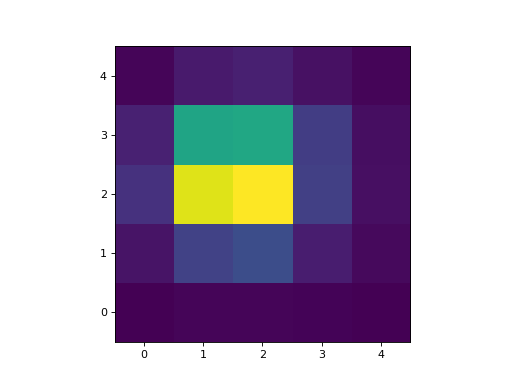

In [206]:
plt.figure()
plt.imshow(iso[0,0],origin='')

In [13]:
-2.5*np.log10(counts) + 20.44

15.328698940505586

In [32]:
isoc = np.nansum(fil)

,RAJ2000,DEJ2000,objID,f_objID,Qual,e_RAJ2000,e_DEJ2000,_tab1_10,Ns,Nd,...,zmag,e_zmag,zKmag,e_zKmag,zFlags,ymag,e_ymag,yKmag,e_yKmag,yFlags
508,189.141033,10.790621,120941891412709097,310697984,37,0.0551,0.0352,56309.635961,0,24,...,20.0248,0.1179,18.918,0.0722,16777496,19.5359,0.0535,18.894,0.2538,16777496


In [71]:
r = 0.677
i = 0.975*1.2
z = 0.977
y = 0.673
factor = np.array([r,i,z,y])
factor = np.array([0.94691754, 0.98808461, 1.03382218, 1.1097075 ])

In [72]:
filts[:,ind] * factor.T

array([19.7008088 , 20.13261916, 20.70208239, 21.67913475])

In [75]:
f = 10**(-1/2.5*(filts[:,ind]+48.6)) *factor
f = np.nansum(f)
m = -2.5*np.log10(f) - 48.6

In [79]:
10**(-1/2.5*(m- 20.44))

5.792309194001244

In [77]:
np.nansum(f)

1.4023348806353871e-27

In [78]:
counts

408.8258934020996